/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003/000001_depth.png
trans: [ 0.04860717 -0.05973635  0.7243121 ]
euler: (2.630710352526467, -1.0068332428800417, -1.031148703571841)
0.09511780738830566
[87 87 87 87 87 88 88 88 88 88 88 88 89 89 89 89 90 90 90 90]
[495 507 513 514 516 491 495 499 503 508 513 515 495 499 500 513 496 498
 499 510]


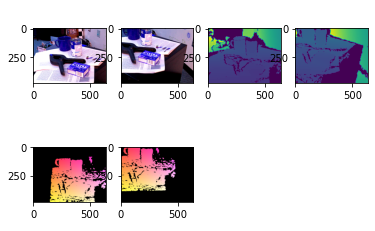

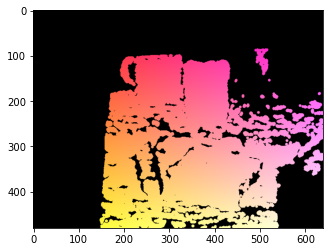

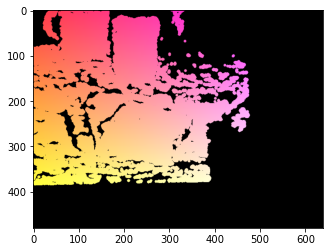

[[2.276 2.276 2.276 ... 1.374 1.373 1.376]
 [2.276 2.278 2.279 ... 1.376 1.376 1.377]
 [2.276 2.282 2.287 ... 1.378 1.377 1.377]
 ...
 [0.574 0.574 0.574 ... 1.424 1.422 1.422]
 [0.574 0.574 0.573 ... 1.424 1.422 1.422]
 [0.573 0.573 0.573 ... 1.423 1.422 1.422]]
/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003/000001_depth.png
trans: [ 0.04860717 -0.05973635  0.7243121 ]
euler: (2.630710352526467, -1.0068332428800417, -1.031148703571841)
0.07063627243041992
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[476 494 495 496 505 507 510 511 512 519 523 524 525 526 527 528 529 530
 531 532]


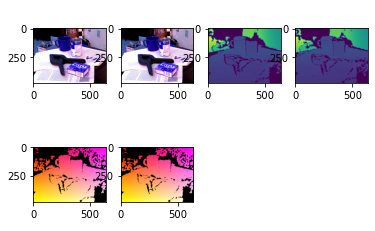

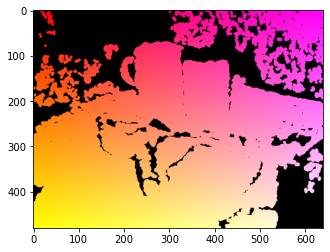

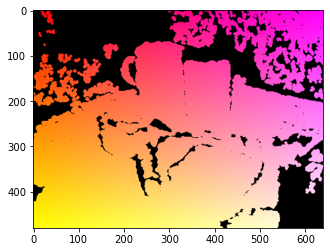

[[0.    0.    0.    ... 1.7   1.697 1.697]
 [0.    0.    0.    ... 1.7   1.697 1.697]
 [0.    0.    0.    ... 1.7   1.698 1.698]
 ...
 [0.531 0.531 0.531 ... 0.    0.    0.   ]
 [0.531 0.531 0.531 ... 0.    0.    0.   ]
 [0.531 0.531 0.53  ... 0.    0.    0.   ]]


NameError: name 'plt' is not defined

In [1]:
# --------------------------------------------------------
# Deep Iterative Matching Network
# Licensed under The Apache-2.0 License [see LICENSE for details]
# Written by Yi Li
# --------------------------------------------------------
from __future__ import print_function, division
import numpy as np
import os 
import sys

#sys.path.insert(0, os.getcwd())
#sys.path.append(os.path.join(os.getcwd() + '/src'))
sys.path.append('/home/jonfrey/mx-DeepIM')

from lib.utils.projection import se3_inverse, se3_mul, backproject_camera
from time import time


def calc_flow(depth_src, pose_src, pose_tgt, K, depth_tgt, thresh=3e-3, standard_rep=False):
    """
    project the points in source corrd to target corrd
    :param standard_rep:
    :param depth_src: depth image of source(m)
    :param pose_src: pose matrix of soucre, [R|T], 3x4
    :param depth_tgt: depth image of target
    :param pose_tgt: pose matrix of target, [R|T], 3x4
    :param K: intrinsic_matrix
    :param depth_tgt: depth image of target(m)
    :return: visible: whether points in source can be viewed in target
    :return: flow: flow from source to target
    """
    height = depth_src.shape[0]
    width = depth_src.shape[1]
    visible = np.zeros(depth_src.shape[:2]).flatten()
    X = backproject_camera(depth_src, intrinsic_matrix=K)
    transform = np.matmul(K, se3_mul(pose_tgt, se3_inverse(pose_src)))
    Xp = np.matmul(transform, np.append(X, np.ones([1, X.shape[1]], dtype=np.float32), axis=0))

    pz = Xp[2] + 1e-15
    pw = Xp[0] / pz
    ph = Xp[1] / pz

    valid_points = np.where(depth_src.flatten() != 0)[0]
    depth_proj_valid = pz[valid_points]
    pw_valid_raw = np.round(pw[valid_points]).astype(int)
    pw_valid = np.minimum(np.maximum(pw_valid_raw, 0), width - 1)
    ph_valid_raw = np.round(ph[valid_points]).astype(int)
    ph_valid = np.minimum(np.maximum(ph_valid_raw, 0), height - 1)
    p_within = np.logical_and(
        np.logical_and(pw_valid_raw >= 0, pw_valid_raw < width),
        np.logical_and(ph_valid_raw >= 0, ph_valid_raw < height))

    depth_tgt_valid = depth_tgt[ph_valid, pw_valid]

    p_within = np.logical_and(p_within, np.abs(depth_tgt_valid - depth_proj_valid) < thresh)
    p_valid = np.abs(depth_tgt_valid) > 1e-10
    fg_points = valid_points[np.logical_and(p_within, p_valid)]
    visible[fg_points] = 1
    visible = visible.reshape(depth_src.shape[:2])
    w_ori, h_ori = np.meshgrid(np.linspace(0, width - 1, width), np.linspace(0, height - 1, height))
    if standard_rep:
        flow = np.dstack([pw.reshape(depth_src.shape[:2]) - w_ori, ph.reshape(depth_src.shape[:2]) - h_ori])
    else:
        # depleted version, only used in old code
        flow = np.dstack([ph.reshape(depth_src.shape[:2]) - h_ori, pw.reshape(depth_src.shape[:2]) - w_ori])
    flow[np.dstack([visible, visible]) != 1] = 0
    assert np.isnan(flow).sum() == 0
    X_valid = np.array([c[np.where(visible.flatten())] for c in X])
    return flow, visible, X_valid

def run (idx1,idx2):
     # only for debug
    import cv2
    import scipy.io as scio
    obj = '005_tomato_soup_can'
    model = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
    base = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003'

    im_src = cv2.imread(f'{base}/{idx1}-color.png',cv2.IMREAD_COLOR)
    im_tgt = cv2.imread(f'{base}/{idx2}-color.png', cv2.IMREAD_COLOR)
    print(f'{base}/{idx1}_depth.png')
    depth_src = ( cv2.imread(f'{base}/{idx1}-depth.png',cv2.IMREAD_UNCHANGED).astype(np.float32) / 10000 )
    depth_tgt = ( cv2.imread(f'{base}/{idx2}-depth.png',cv2.IMREAD_UNCHANGED).astype(np.float32) / 10000 )

    pose_src = scio.loadmat(f'{base}/{idx1}-meta.mat')['poses'][:, :, 0]
    pose_tgt = scio.loadmat(f'{base}/{idx2}-meta.mat')['poses'][:, :, 0]

    if True:
        from lib.pair_matching import RT_transform

        print("trans: {}".format(pose_src[:, -1]))
        print("euler: {}".format(RT_transform.mat2euler(pose_src[:, :3])))

    K = np.array([[1066.778, 0, 312.9869], [0, 1067.487, 241.3109], [0, 0, 1]])
    t = time()
    flow, visible,X_valid = calc_flow(depth_src, pose_src, pose_tgt, K, depth_tgt)
    print(time() - t)
    a = np.where(np.squeeze(visible[:, :]))
    print(a[0][:20])
    print(a[1][:20])
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.axis("off")
    fig.add_subplot(2, 4, 1)
    plt.imshow(im_src)
    fig.add_subplot(2, 4, 2)
    plt.imshow(im_tgt)
    fig.add_subplot(2, 4, 3)
    plt.imshow(depth_src)
    fig.add_subplot(2, 4, 4)
    plt.imshow(depth_tgt)

    fig.add_subplot(2, 4, 5)
    height = depth_src.shape[0]
    width = depth_src.shape[1]
    img_tgt = np.zeros((height, width, 3), np.uint8)
    img_src = np.zeros((height, width, 3), np.uint8)
    for h in range(height):
        for w in range(width):
            if visible[h, w]:
                cur_flow = flow[h, w, :]
                img_src = cv2.line(
                    img_src,
                    (np.round(w).astype(int), np.round(h).astype(int)),
                    (np.round(w).astype(int), np.round(h).astype(int)),
                    (255, h * 255 / height, w * 255 / width),
                    5)
                img_tgt = cv2.line(
                    img_tgt,
                    (np.round(w + cur_flow[1]).astype(int), np.round(h + cur_flow[0]).astype(int)),
                    (np.round(w + cur_flow[1]).astype(int), np.round(h + cur_flow[0]).astype(int)),
                    (255, h * 255 / height, w * 255 / width),
                    5)
    plt.imshow(img_src)
    fig.add_subplot(2, 4, 6)
    plt.imshow(img_tgt)
    plt.show()
    
    fig2 = plt.figure()
    plt.imshow(img_src)
    plt.show()
    fig3 = plt.figure()
    plt.imshow(img_tgt)
    plt.show()
    print(depth_tgt)
    return img_src, img_tgt
if __name__ == "__main__":
    img_src1, img_tgt1 = run(idx1 = "000001", idx2 = "000100")
    img_src2, img_tgt2 =run(idx1 = "000001", idx2 = "000002")
    fig = plt.figure()
    plt.axis("off")
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_tgt1)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img_tgt2)
    plt.show()
    


In [2]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'osmesa' # 'egl'

import trimesh
import numpy as np
import trimesh
import pyrender
#print(pyglet)
# from random import choice
# import random
# import PIL
from math import pi
from PIL import Image
# import imageio
import copy
# from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
# import gc
import time
import cv2
import scipy.io as scio

ImportError: ('Unable to load OpenGL library', 'libOSMesa.so.8: cannot open shared object file: No such file or directory', 'libOSMesa.so.8', 'libOSMesa.so.8')

In [10]:
obj = '005_tomato_soup_can'
model = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
base = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003'
idx1 = '000010'
im_src = cv2.imread(f'{base}/{idx1}-color.png',cv2.IMREAD_COLOR)
depth_src = ( cv2.imread(f'{base}/{idx1}-depth.png',cv2.IMREAD_UNCHANGED).astype(np.float32) / 10000 )
pose_src = scio.loadmat(f'{base}/{idx1}-meta.mat')['poses'][:, :, 0]

# trimeshes = [trimesh.load(x + '/geometry.ply') for x in seq_paths]
# meshs = [pyrender.Mesh.from_trimesh(
# trimesh.load(x + '/geometry.ply')) for x in seq_paths]
# vertices, indices = data.objload(f'{model}/{obj}/textured.obj', rescale=False)
# texture_map = data.load(f'{model_folder}/texture_map.png')[::-1, :, :])


bill_trimesh = trimesh.load(f'{model}/{obj}/textured.obj')
mesh = pyrender.Mesh.from_trimesh(bill_trimesh, smooth=False, wireframe=True)

scene = pyrender.Scene()
scene.add(mesh)
ren = pyrender.OffscreenRenderer(600, 600, point_size=5)

#pyrender.Viewer(scene, use_raymond_lighting=True)
color, depth = ren.render(scene)
                          
#     print("render_time:", time.time() - t_render)
#     # Show the images
#     t_render = time.time()
#     plt.axis('off')
plt.imshow(color)  # imshow


GLError: GLError(
	err = 12297,
	baseOperation = eglCreateContext,
	cArguments = (
		<OpenGL._opaque.EGLDisplay_pointer object at 0x7ff34b00ac20>,
		<OpenGL._opaque.EGLConfig_pointer object at 0x7ff34b00acb0>,
		<OpenGL._opaque.EGLContext_pointer object at 0x7ff34bcdb0e0>,
		<OpenGL.arrays.lists.c_int_Array_7 object at 0x7ff383fd2dd0>,
	),
	result = <OpenGL._opaque.EGLContext_pointer object at 0x7ff34b015320>
)

In [ ]:

#     outpath = path_seq + '/%i.png' % k
#     outpathd = path_seq + '/%id.png' % k
#     outpathmeta = path_seq + '/%i_meta.npy' % k

# plt.figure()
# plt.subplot(1, 1, 1)

# st = time.time()

# scene = pyrender.Scene(bg_color=(0, 0, 0, 255))
# scene.clear()
# ren = pyrender.OffscreenRenderer(600, 600, point_size=5)
# pose = np.eye(4)
# pose[0, 3] = x_range[x_idx_obj[j]]
# pose[1, 3] = y_range[y_idx_obj[j]]
# pose[2, 3] = z_range[z_idx_obj[j]]
# pose[:3, :3] = r.as_matrix()
# node_list.append(scene.add(meshs[idx], pose=pose))
# obj_node = scene.add(meshs[obj_idx], pose=pose)

# # Set camera and lighting
# cx = 300
# cy = 300
# fx = 1066.778
# fy = 1067.487
# camera = pyrender.IntrinsicsCamera(
#     fx, fy, cx, cy, znear=0.00001, zfar=10000.0, name=None)
# camera_pose = np.array([
#     [1, 0, 0, 0],
#     [0, -1, 0.0, 0],
#     [0.0, 0, -1, 0],
#     [0.0, 0.0, 0.0, 1.0],
# ])
# light = pyrender.SpotLight(color=np.ones(3), intensity=35.0,
#                            innerConeAngle=np.pi / 10.0)
# scene.add(light, pose=camera_pose)
# st2 = time.time()
# scene.add(camera, pose=camera_pose)

# k = 0

#     # scene = copy.copy(scene_store)
#     scene.set_pose(obj_node, pose=pose)

#     pose[:3, 3] += obj_v

#     # Render the scen
#     t_render = time.time()
#     color, depth = ren.render(scene)
#     print("render_time:", time.time() - t_render)
#     # Show the images
#     t_render = time.time()
#     plt.axis('off')
#     plt.imshow(color)  # imshow

#     outpath = path_seq + '/%i.png' % k
#     outpathd = path_seq + '/%id.png' % k
#     outpathmeta = path_seq + '/%i_meta.npy' % k
# ren.delete()

if save:

            # magic 45 degree rotation.
            pose2 = np.eye(4)
            pose2[:3, :3] = R.from_euler('z', -45, degrees=True).as_matrix()

            meta = {'pose_se3': pose,
                    'cx': cx,
                    'cy': cy,
                    'fx': fx,
                    'fy': fy}
            np.save(outpathmeta, meta)

            img = Image.fromarray(color)
            img = img.convert("RGBA")
            datas = img.getdata()

            newData = []

            # make white pixles transparent
            for item in datas:
                if item[0] == 0 and item[1] == 255 and item[2] == 0:
                    newData.append((255, 255, 255, 0))
                else:
                    newData.append(item)
            img.putdata(newData)
            img.save(outpath, "PNG")
            # converte depth into 1*mm -> max range 6 meter
            depth_store = np.array(depth * 1000, dtype=np.uint16)
            depth_store[depth_store == 0] = 65536

            imageio.imwrite(outpathd, depth_store)
        else:
            print("show")
            plt.axis('on')
            plt.show()
        print("store_time:", time.time() - t_render)

        k += 1